In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Глобальные переменные
x0 = 1 # Начальное положение
v0 = 1 # Начальная скорость
omega0 = 2 * np.pi * 2  # Частота

# Устройства для вычислений (GPU если доступен)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Нейронная сеть для PINN

In [70]:
class PINNModel(nn.Module):
    def __init__(self, hidden_size=20):
        super(PINNModel, self).__init__()
        self.layers_stack = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.layers_stack(x)

### Аналитическое решение для системы с внешней силой cos(ωt)

In [71]:
import torch

def analytic_solution(t):
    global x0, v0, omega0

    # Ensure omega is a tensor
    omega = torch.tensor(omega0, dtype=torch.float32)

    # Damping coefficient as a tensor
    gamma = omega / 10.0

    # Damped angular frequency as a tensor
    omega_d = torch.sqrt(omega**2 - gamma**2)

    # Calculate constants A and B using initial conditions
    A = x0
    B = (v0 + gamma * x0) / omega_d

    # Compute exponential, sine, and cosine terms
    exp_term = torch.exp(-gamma * t)
    cos_term = torch.cos(omega_d * t)
    sin_term = torch.sin(omega_d * t)

    # Вычисление позиции
    x = exp_term * (A * cos_term + B * sin_term)

    # Вычисление скорости
    v = exp_term * (
        -gamma * (A * cos_term + B * sin_term)
        - A * omega_d * sin_term
        + B * omega_d * cos_term
    )

    # Вычисление ускорения
    a = exp_term * (
        (gamma**2 - omega_d**2) * (A * cos_term + B * sin_term)
        + 2 * gamma * omega_d * (A * sin_term - B * cos_term)
    )

    return x, v, a


### Определяем уравнения для разных формулировок

In [72]:
# 1. Для второй формулировки (второй порядок ОДУ)
def pde_second_order(x, t, omega):
    dxdt = torch.autograd.grad(outputs=x, inputs=t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    d2xdt2 = torch.autograd.grad(outputs=dxdt, inputs=t, grad_outputs=torch.ones_like(dxdt), create_graph=True)[0]
    F = torch.cos(omega * t)  # Внешняя сила
    residual = d2xdt2 + omega**2 * x - F  # Резидуал уравнения
    return residual, dxdt, d2xdt2

# 2. Для первой системы (первый порядок)
def pde_first_order(x, y, t, omega):
    y = torch.autograd.grad(outputs=x, inputs=t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    F = torch.cos(omega * t)  # Внешняя сила
    dydt = - omega**2 * x + F
    return x, y, dydt

# 3. Для альтернативной первой системы
def pde_alternative(x, y, t, omega):
    y = torch.autograd.grad(outputs=x, inputs=t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    dxdt = omega * y + (1/omega) * torch.sin(omega * t)
    dydt = -omega * x
    return dxdt, dydt

### Функция потерь для сравнения

In [73]:
# Функция для вычисления метрик
def metric_data(a, b):
    return torch.mean((a - b)**2)

# Функция потерь с учетом начальных условий и весовых коэффициентов
def loss_fn(formulation, model, t, omega, weight_pde=1.0, weight_bc=1000.0):
    global x0, v0, omega0
    # Получаем решение модели
    if formulation == 1:
        # Начальные условия
        x0_true = torch.tensor(x0).to(device)
        v0_true = torch.tensor(v0).to(device)

        x = model(t)
        res, dxdt, d2xdt2 = pde_second_order(x, t, omega)
        loss_pde = metric_data(res, torch.zeros_like(res))

        # Поиск индексов, где t == 0
        inlet_mask = (t[:, 0] == 0.0)
        if inlet_mask.any():
            t0 = t[inlet_mask]
            x0_pred = model(t0)
            dxdt0 = torch.autograd.grad(outputs=x0_pred, inputs=t0, grad_outputs=torch.ones_like(x0_pred), create_graph=True)[0]

            # Вычисляем потери по начальному условию
            loss_bc_x = metric_data(x0_pred, x0_true)
            loss_bc_dxdt = metric_data(dxdt0, v0_true)
            loss_bc = loss_bc_x + loss_bc_dxdt
        else:
            loss_bc = torch.tensor(0.0, device=device)

        # Общая функция потерь с весовыми коэффициентами
        loss = weight_pde * loss_pde + weight_bc * loss_bc

        # Вычисление метрик для мониторинга
        x_true = x0_true * torch.sin(omega * t + torch.pi / 2)
        metric_x = metric_data(x, x_true)

        return loss, loss_pde, loss_bc, metric_x, x, dxdt, d2xdt2
    elif formulation == 2:
        y = model(t)
        x = y[:, 0:1]
        res1, res2 = pde_first_order(x, y, t, omega)
        return torch.mean(res1**2 + res2**2), x, res1, res2
    elif formulation == 3:
        y = model(t)
        x = y[:, 0:1]
        res1, res2 = pde_alternative(x, y, t, omega)
        return torch.mean(res1**2 + res2**2), x, res1, res2

### Обучение модели

In [74]:
def train_model(formulation, omega, t, epochs=5000, learning_rate=0.001):
    model = PINNModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    loss_history = []
    loss_pde_history = []
    loss_bc_history = []
    metric_x_history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, loss_pde, loss_bc, metric_x, x, dxdt, d2xdt2 = loss_fn(formulation, model, t, omega)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        loss_pde_history.append(loss_pde.item())
        loss_bc_history.append(loss_bc.item())
        metric_x_history.append(metric_x.item())

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}/{epochs}, Total Loss: {loss.item():.6f}, PDE Loss: {loss_pde.item():.6f}, BC Loss: {loss_bc.item():.6f}, Metric x: {metric_x.item():.6f}")

    return model, loss_history, loss_pde_history, loss_bc_history, metric_x_history, x, dxdt, d2xdt2

In [75]:
# Тестирование модели
def test_model(model, t):
    with torch.no_grad():
        x_pred = model(t)
    return x_pred

# Время и параметры для обучения
t = torch.linspace(0, 5, 500).reshape(-1, 1).to(device)  # Вектор времени
t.requires_grad = True

# Обучаем модели для разных формулировок
model_1, loss_history_1, loss_pde_history_1, loss_bc_history_1, metric_x_history_1, x_1, dxdt_1, d2xdt2_1 = train_model(1, omega0, t, x0, v0)
# model_2, loss_history_2, x_2, dxdt_2, d2xdt2_2 = train_model(2, omega0, t)
# model_3, loss_history_3, x_3, dxdt_3, d2xdt2_3 = train_model(3, omega0, t)

# Тестируем модели
x_pred_1 = test_model(model_1, t)
# x_pred_2 = test_model(model_2, t)
# x_pred_3 = test_model(model_3, t)

# Получаем аналитические решения для x(t), dx/dt(t), d2x/dt2(t)
x_analytic, dxdt_analytic, d2xdt2_analytic = analytic_solution(t)

Epoch 0/1, Total Loss: 2109.737793, PDE Loss: 126.553131, BC Loss: 1.983185, Metric x: 0.506248


### Визуализация результатов

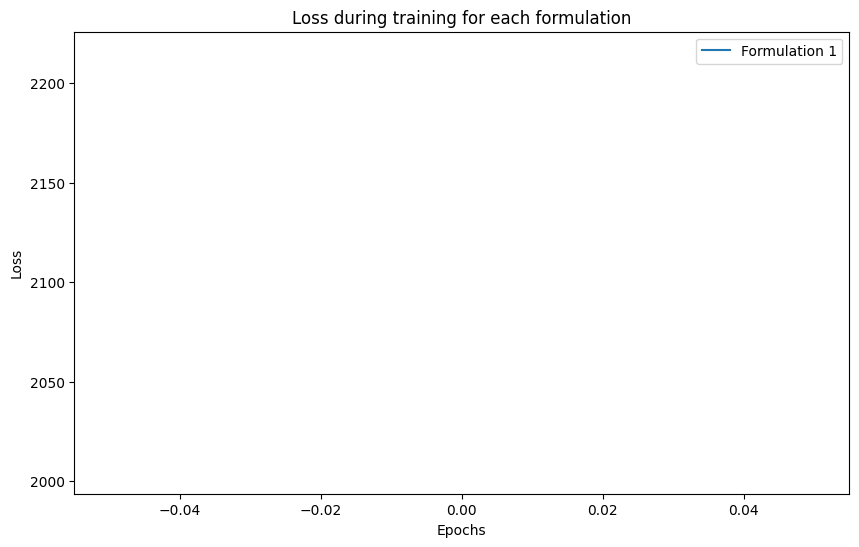

In [76]:
# График потерь для каждой формулировки
plt.figure(figsize=(10, 6))
plt.plot(loss_history_1, label='Formulation 1')
# plt.plot(loss_history_2, label='Formulation 2')
# plt.plot(loss_history_3, label='Formulation 3')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during training for each formulation')
plt.savefig('loss_comparison.png')
plt.show()

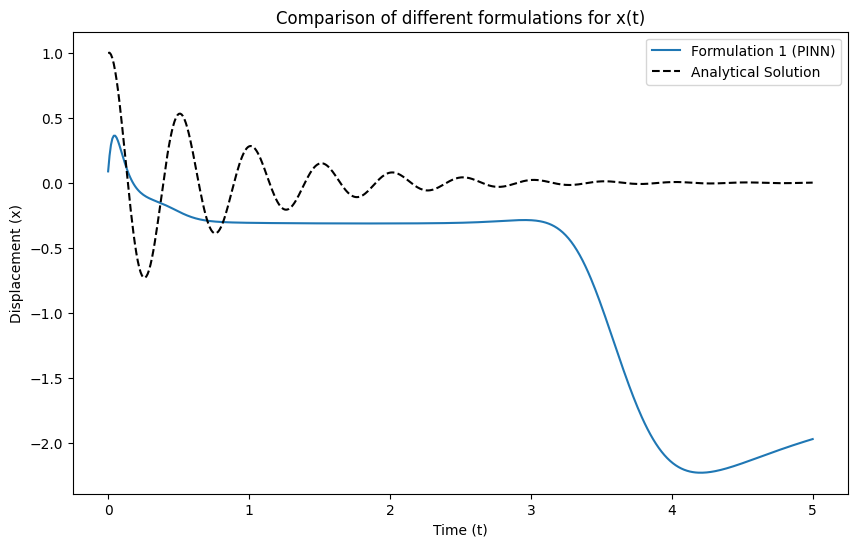

"\n# 2. Зависимость dx/dt от t для всех формулировок и аналитического решения\nplt.figure(figsize=(10, 6))\nplt.plot(t.cpu().detach().numpy(), dxdt_1.cpu().detach().numpy(), label='Formulation 1 (PINN)')\n# plt.plot(t.cpu().detach().numpy(), dxdt_2.cpu().detach().numpy(), label='Formulation 2 (PINN)')\n# plt.plot(t.cpu().detach().numpy(), dxdt_3.cpu().detach().numpy(), label='Formulation 3 (PINN)')\nplt.plot(t.cpu().detach().numpy(), dxdt_analytic.cpu().detach().numpy(), label='Analytical dx/dt', linestyle='dashed', color='black')\nplt.legend()\nplt.xlabel('Time (t)')\nplt.ylabel('Velocity (dx/dt)')\nplt.title('Comparison of different formulations for dx/dt(t)')\nplt.savefig('dxdt_comparison_with_analytic.png')\nplt.show()\n\n# 3. Зависимость d2x/dt2 от t для всех формулировок и аналитического решения\nplt.figure(figsize=(10, 6))\nplt.plot(t.cpu().detach().numpy(), d2xdt2_1.cpu().detach().numpy(), label='Formulation 1 (PINN)')\n# plt.plot(t.cpu().detach().numpy(), d2xdt2_2.cpu().detach

In [77]:
# График x от t для всех формулировок и аналитического решения
plt.figure(figsize=(10, 6))
plt.plot(t.cpu().detach().numpy(), x_pred_1.cpu().detach().numpy(), label='Formulation 1 (PINN)')
#plt.plot(t.cpu().detach().numpy(), x_pred_2.cpu().detach().numpy(), label='Formulation 2 (PINN)')
#plt.plot(t.cpu().detach().numpy(), x_pred_3.cpu().detach().numpy(), label='Formulation 3 (PINN)')
plt.plot(t.cpu().detach().numpy(), x_analytic.cpu().detach().numpy(), label='Analytical Solution', linestyle='dashed', color='black')
plt.legend()
plt.xlabel('Time (t)')
plt.ylabel('Displacement (x)')
plt.title('Comparison of different formulations for x(t)')
plt.savefig('disp2time_comparison_with_analytic.png')
plt.show()

"""
# 2. Зависимость dx/dt от t для всех формулировок и аналитического решения
plt.figure(figsize=(10, 6))
plt.plot(t.cpu().detach().numpy(), dxdt_1.cpu().detach().numpy(), label='Formulation 1 (PINN)')
# plt.plot(t.cpu().detach().numpy(), dxdt_2.cpu().detach().numpy(), label='Formulation 2 (PINN)')
# plt.plot(t.cpu().detach().numpy(), dxdt_3.cpu().detach().numpy(), label='Formulation 3 (PINN)')
plt.plot(t.cpu().detach().numpy(), dxdt_analytic.cpu().detach().numpy(), label='Analytical dx/dt', linestyle='dashed', color='black')
plt.legend()
plt.xlabel('Time (t)')
plt.ylabel('Velocity (dx/dt)')
plt.title('Comparison of different formulations for dx/dt(t)')
plt.savefig('dxdt_comparison_with_analytic.png')
plt.show()

# 3. Зависимость d2x/dt2 от t для всех формулировок и аналитического решения
plt.figure(figsize=(10, 6))
plt.plot(t.cpu().detach().numpy(), d2xdt2_1.cpu().detach().numpy(), label='Formulation 1 (PINN)')
# plt.plot(t.cpu().detach().numpy(), d2xdt2_2.cpu().detach().numpy(), label='Formulation 2 (PINN)')
# plt.plot(t.cpu().detach().numpy(), d2xdt2_3.cpu().detach().numpy(), label='Formulation 3 (PINN)')
plt.plot(t.cpu().detach().numpy(), d2xdt2_analytic.cpu().detach().numpy(), label='Analytical d2x/dt2', linestyle='dashed', color='black')
plt.legend()
plt.xlabel('Time (t)')
plt.ylabel('Acceleration (d2x/dt2)')
plt.title('Comparison of different formulations for d2x/dt2(t)')
plt.savefig('d2xdt2_comparison_with_analytic.png')
plt.show()
"""
